In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用指定GPU
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder, CIFAR100
from torchtoolbox.tools import summary
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


device = get_default_device()
print('检查GPU是否可用：',device)
!nvidia-smi

检查GPU是否可用： cuda
Sun May  8 20:10:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:0C:00.0 Off |                  N/A |
| 32%   40C    P8    40W / 350W |   6437MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:0D:00.0 Off |                

# 从kaggle下载数据集CIFAR-100数据集

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/c/2021-ai-training/data')

Skipping, found downloaded files in "./2021-ai-training" (use force=True to force download)


In [2]:
data_dir = './2021-ai-training/CIFAR100'
classes = os.listdir(data_dir + "/TRAIN")
print(classes)

['chair', 'rocket', 'fox', 'poppy', 'apple', 'trout', 'palm_tree', 'seal', 'bridge', 'kangaroo', 'aquarium_fish', 'dolphin', 'beetle', 'pickup_truck', 'plain', 'can', 'snake', 'squirrel', 'skunk', 'lizard', 'bicycle', 'bottle', 'caterpillar', 'flatfish', 'shrew', 'lion', 'skyscraper', 'leopard', 'mountain', 'orange', 'porcupine', 'chimpanzee', 'motorcycle', 'hamster', 'otter', 'bee', 'mouse', 'worm', 'mushroom', 'cockroach', 'crocodile', 'bowl', 'willow_tree', 'lobster', 'train', 'road', 'tank', 'rose', 'streetcar', 'camel', 'lawn_mower', 'table', 'oak_tree', 'tiger', 'bear', 'woman', 'pine_tree', 'dinosaur', 'bus', 'bed', 'butterfly', 'man', 'shark', 'sunflower', 'raccoon', 'wardrobe', 'rabbit', 'crab', 'beaver', 'lamp', 'cattle', 'orchid', 'ray', 'elephant', 'clock', 'baby', 'boy', 'castle', 'cup', 'forest', 'possum', 'sweet_pepper', 'telephone', 'maple_tree', 'tulip', 'girl', 'pear', 'television', 'whale', 'spider', 'snail', 'wolf', 'house', 'keyboard', 'couch', 'cloud', 'turtle', '

In [4]:
!nvidia-smi

Sun May  8 03:29:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:0C:00.0 Off |                  N/A |
| 88%   60C    P8    52W / 350W |      2MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:0D:00.0 Off |                  N/A |
| 35%   

In [3]:
'''
数据预处理
'''

method='null'


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """

    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            # (x,y)表示方形补丁的中心位置
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img


normalize = tt.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
train_tfms = tt.Compose([
        tt.RandomCrop(32, padding=4),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        normalize,
])

if method=='cutout':
    #train_tfms.append(Cutout(n_holes=1, length=16))
    tt.Compose([
        tt.RandomCrop(32, padding=4),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        normalize,
        Cutout(n_holes=1, length=8),
])
    
valid_tfms = tt.Compose([
#         tt.Resize(256),  # transforms.Scale(256)
#         tt.CenterCrop(224),
        tt.ToTensor(),
        normalize,
])

# 对数据做标准化
# 训练集与测试集
train_ds = ImageFolder(root=data_dir+"/TRAIN",transform=train_tfms)
valid_ds = ImageFolder(root=data_dir+"/TEST",transform=valid_tfms)

# 用pytorh读取数据
BATCH_SIZE=128
train_dl = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds,batch_size=100, shuffle=False, num_workers=2)

#用CGPU读取数据集
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device) 


In [4]:


'''
数据增强方法
'''
def mixup_data(x, y, alpha=1, device=torch.device("cuda")):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    index = index.to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


# def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred, y_a) + (1. - lam) * criterion(pred, y_b)



def cutmix_data(x, y, alpha=1.0, device=torch.device("cuda")):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    rand_index = torch.randperm(x.size()[0]).to(device)
    y_a = y
    y_b = y[rand_index]
    bbx1, bby1, bbx2, bby2 = _rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam


# def cutmix_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred, y_a) + (1. - lam) * criterion(pred, y_b)


def _rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [5]:


'''
DenseNet模型
'''
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class ImageClassificationBase(nn.Module):
    def training_step(self,batch,method):
        '''
        这里更改方法
        '''
        if method=='null' or method=='cutout':
            images,labels = batch
            out = self(images)
            loss = F.cross_entropy(out,labels)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        elif method=='mixup':
            images,labels = batch
            inputs, targets_a, targets_b, lam = mixup_data(images, labels)
            out = self(inputs)
            loss = lam * F.cross_entropy(out, targets_a) + (1. - lam) * F.cross_entropy(out, targets_b)
        elif method=='cutmix':
            images,labels = batch
            r = np.random.rand(1)
            cutmix_prob=0.5
            if r < cutmix_prob:
                inputs, targets_a, targets_b, lam = cutmix_data(images, labels)
                out = self(inputs)
                loss = lam * F.cross_entropy(out, targets_a) + (1. - lam) * F.cross_entropy(out, targets_b)
            else:
                out = self(images)
                loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
        

class DenseNet_Cifar(ImageClassificationBase):
    def __init__(self, growth_rate=12, block_config=(16, 16, 16),
                 num_init_features=24, bn_size=4, drop_rate=0, num_classes=10):

        super(DenseNet_Cifar, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        
        # initialize conv and bn parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=8, stride=1).view(features.size(0), -1)
        out = self.classifier(out)
        return out


def densenet_BC_cifar(depth, k, **kwargs):
    N = (depth - 4) // 6
    model = DenseNet_Cifar(growth_rate=k, block_config=[N, N, N], num_init_features=2*k, **kwargs)
    return model


In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def adjust_learning_rate(optimizer, epoch):
    if epoch < 75:
        lrr = lr
    elif epoch < 112:
        lrr = lr * 0.1
    else:
        lrr = lr * 0.01
    for param_group in optimizer.param_groups:
        param_group['lr'] = lrr
        

In [7]:


'''
训练
'''
import math
#调节depth可以调节层数
model = densenet_BC_cifar(depth=100, k=12, num_classes=100)
model = to_device(model,device)

epochs=300
lr=0.1
momentum=0.9
weight_decay=1e-4
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)

def Train (epochs,train_dl,valid_dl,model,optimizer,method):
    torch.cuda.empty_cache()
    
    history = []
        
    for epoch in range(epochs):
        adjust_learning_rate(optimizer, epoch)
        model.train()
        train_loss = []
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch,method)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            train_loss.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lrs.append(get_lr(optimizer))

    
        result = evaluate(model,valid_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            

@torch.no_grad()
def evaluate(model,valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# CutMix

In [8]:
print('cutmix训练过程：')
history_cutmix = []
history_cutmix += Train(epochs=epochs,train_dl=train_dl,valid_dl=valid_dl,model=model,optimizer=optimizer,method='cutmix')


torch.save(model.state_dict(),'model_cutmix.pt')

cutmix训练过程：


<ipython-input-4-208cd64da7c0>:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-4-208cd64da7c0>:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more det

Epoch [0], last_lr: 0.10000, train_loss: 4.0810, val_loss: 3.6960, val_acc: 0.1347
Epoch [1], last_lr: 0.10000, train_loss: 3.6430, val_loss: 3.4220, val_acc: 0.1820
Epoch [2], last_lr: 0.10000, train_loss: 3.3197, val_loss: 2.8246, val_acc: 0.2753
Epoch [3], last_lr: 0.10000, train_loss: 3.0035, val_loss: 2.5475, val_acc: 0.3457
Epoch [4], last_lr: 0.10000, train_loss: 2.8367, val_loss: 2.3056, val_acc: 0.3899
Epoch [5], last_lr: 0.10000, train_loss: 2.6738, val_loss: 2.2769, val_acc: 0.4015
Epoch [6], last_lr: 0.10000, train_loss: 2.5114, val_loss: 2.0142, val_acc: 0.4588
Epoch [7], last_lr: 0.10000, train_loss: 2.4325, val_loss: 2.0654, val_acc: 0.4493
Epoch [8], last_lr: 0.10000, train_loss: 2.3729, val_loss: 1.9683, val_acc: 0.4754
Epoch [9], last_lr: 0.10000, train_loss: 2.3655, val_loss: 1.7681, val_acc: 0.5190
Epoch [10], last_lr: 0.10000, train_loss: 2.2831, val_loss: 1.7131, val_acc: 0.5204
Epoch [11], last_lr: 0.10000, train_loss: 2.2316, val_loss: 1.6681, val_acc: 0.5472
Ep

Epoch [98], last_lr: 0.01000, train_loss: 1.0995, val_loss: 0.8297, val_acc: 0.7722
Epoch [99], last_lr: 0.01000, train_loss: 0.9669, val_loss: 0.8589, val_acc: 0.7666
Epoch [100], last_lr: 0.01000, train_loss: 0.8757, val_loss: 0.8386, val_acc: 0.7644
Epoch [101], last_lr: 0.01000, train_loss: 1.1605, val_loss: 0.8420, val_acc: 0.7657
Epoch [102], last_lr: 0.01000, train_loss: 1.0024, val_loss: 0.8420, val_acc: 0.7670
Epoch [103], last_lr: 0.01000, train_loss: 1.0100, val_loss: 0.8472, val_acc: 0.7673
Epoch [104], last_lr: 0.01000, train_loss: 0.8896, val_loss: 0.8535, val_acc: 0.7631
Epoch [105], last_lr: 0.01000, train_loss: 1.0134, val_loss: 0.8556, val_acc: 0.7661
Epoch [106], last_lr: 0.01000, train_loss: 0.9622, val_loss: 0.8482, val_acc: 0.7674
Epoch [107], last_lr: 0.01000, train_loss: 0.8157, val_loss: 0.8522, val_acc: 0.7693
Epoch [108], last_lr: 0.01000, train_loss: 0.9520, val_loss: 0.8512, val_acc: 0.7640
Epoch [109], last_lr: 0.01000, train_loss: 0.9793, val_loss: 0.8483

Epoch [195], last_lr: 0.00100, train_loss: 0.9091, val_loss: 0.8298, val_acc: 0.7723
Epoch [196], last_lr: 0.00100, train_loss: 0.9111, val_loss: 0.8374, val_acc: 0.7682
Epoch [197], last_lr: 0.00100, train_loss: 0.9430, val_loss: 0.8380, val_acc: 0.7714
Epoch [198], last_lr: 0.00100, train_loss: 0.9401, val_loss: 0.8385, val_acc: 0.7697
Epoch [199], last_lr: 0.00100, train_loss: 0.8683, val_loss: 0.8356, val_acc: 0.7701
Epoch [200], last_lr: 0.00100, train_loss: 0.8889, val_loss: 0.8337, val_acc: 0.7738
Epoch [201], last_lr: 0.00100, train_loss: 0.7897, val_loss: 0.8328, val_acc: 0.7714
Epoch [202], last_lr: 0.00100, train_loss: 0.8195, val_loss: 0.8622, val_acc: 0.7710
Epoch [203], last_lr: 0.00100, train_loss: 0.8793, val_loss: 0.8337, val_acc: 0.7726
Epoch [204], last_lr: 0.00100, train_loss: 0.9381, val_loss: 0.8404, val_acc: 0.7715
Epoch [205], last_lr: 0.00100, train_loss: 0.8437, val_loss: 0.8387, val_acc: 0.7711
Epoch [206], last_lr: 0.00100, train_loss: 0.9157, val_loss: 0.83

Epoch [292], last_lr: 0.00100, train_loss: 0.9229, val_loss: 0.8458, val_acc: 0.7741
Epoch [293], last_lr: 0.00100, train_loss: 0.9365, val_loss: 0.8618, val_acc: 0.7716
Epoch [294], last_lr: 0.00100, train_loss: 0.9016, val_loss: 0.8467, val_acc: 0.7721
Epoch [295], last_lr: 0.00100, train_loss: 0.8636, val_loss: 0.8453, val_acc: 0.7714
Epoch [296], last_lr: 0.00100, train_loss: 0.8969, val_loss: 0.8595, val_acc: 0.7717
Epoch [297], last_lr: 0.00100, train_loss: 0.8272, val_loss: 0.8445, val_acc: 0.7735
Epoch [298], last_lr: 0.00100, train_loss: 0.8873, val_loss: 0.8400, val_acc: 0.7735
Epoch [299], last_lr: 0.00100, train_loss: 0.8044, val_loss: 0.8644, val_acc: 0.7728


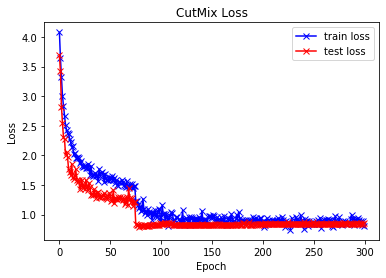

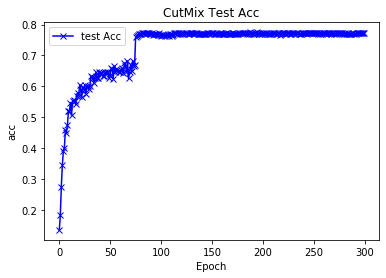

In [9]:
def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","test loss"])
    plt.title('CutMix Loss')
    plt.show()

def plot_testAcc(history):
    plt.plot([x.get("val_acc") for x in history], "-bx")
    plt.xlabel("Epoch")
    plt.ylabel("acc")
    plt.legend(["test Acc"])
    plt.title('CutMix Test Acc')
    plt.show()

plot_loss(history_cutmix)
plot_testAcc(history_cutmix)